# Global settings

In [60]:
%matplotlib inline

#%load_ext autoreload  # Autoreload has a bug : when you modify function in source code and run again, python kernel hangs :(
#%autoreload 2

import datetime as dt

import sys, importlib

from functions import *
importlib.reload(sys.modules['functions'])

import pandas as pd

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

import datetime as dt

import os
import zipfile
import urllib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np   
  
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

import qgrid

import glob

from pandas.plotting import scatter_matrix

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import GridSearchCV

from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import Isomap

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import entropy

from sklearn.feature_selection import RFE

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


import nltk
import codecs

#from nltk.corpus.reader.api import CorpusReader
#from nltk.corpus.reader.api import CategorizedCorpusReader

from nltk import pos_tag, sent_tokenize, wordpunct_tokenize

import pandas_profiling

from bs4 import BeautifulSoup

from yellowbrick.text.freqdist import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer

DATA_PATH = os.path.join("datasets", "stackexchange")
#DATA_PATH = os.path.join(DATA_PATH, "out")

#DATA_PATH_FILE_INPUT = os.path.join(DATA_PATH, "QueryResults_20190101-20200620.csv")
#DATA_PATH_FILE_INPUT = os.path.join(DATA_PATH, "QueryResults 20200301-20200620_1.csv")

DATA_PATH_FILE = os.path.join(DATA_PATH, "*.csv")
ALL_FILES_LIST = glob.glob(DATA_PATH_FILE)

ALL_FEATURES = []

MODEL_CLIENT_FEATURES = ['TotalPricePerMonth', 'DescriptionNormalized', 'HasEverCancelled', 'BoughtTopValueProduct' ]


plt.rcParams["figure.figsize"] = [16,9] # Taille par défaut des figures de matplotlib

import seaborn as sns
from seaborn import boxplot
sns.set()

#import common_functions

####### Paramètres pour sauver et restaurer les modèles :
import pickle
####### Paramètres à changer par l'utilisateur selon son besoin :

'''
RECOMPUTE_GRIDSEARCH = True  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = False # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = False # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX
                          # Grid search results are loaded with full samples (SAMPLED_DATA must be False)
'''


RECOMPUTE_GRIDSEARCH = False  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = False # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = True # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX

#GRIDSEARCH_CSV_FILE = 'grid_search_results.csv'

GRIDSEARCH_FILE_PREFIX = 'grid_search_results_'

EXECUTE_INTERMEDIATE_MODELS = True # If True: every intermediate model (which results are manually analyzed in the notebook) will be executed


# Necessary for predictors used in the notebook :
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import PolynomialFeatures

### For progress bar :
from tqdm import tqdm_notebook as tqdm

# Statsmodel : 
import statsmodels.formula.api as smf

import statsmodels.api as sm
from scipy import stats

SAVE_API_MODEL = True # If True : API model ill be saved
API_MODEL_PICKLE_FILE = 'API_model_PJ6.pickle'


In [2]:
ALL_FILES_LIST

['datasets/stackexchange/QueryResults 20200301-20200620_1.csv',
 'datasets/stackexchange/QueryResults 20200301-20200620_6.csv',
 'datasets/stackexchange/QueryResults 20200301-20200620_2.csv',
 'datasets/stackexchange/QueryResults 20200301-20200620_5.csv',
 'datasets/stackexchange/QueryResults 20200301-20200620_4.csv',
 'datasets/stackexchange/QueryResults 20200301-20200620_3.csv']

# Load data

In [3]:
import pandas as pd

pd.set_option('display.max_columns', None)

feats_list = ['Title', 'Body', 'Tags']

def load_data(data_path=DATA_PATH):
    csv_path = DATA_PATH_FILE
    df_list = []
    
    for f in ALL_FILES_LIST:
        print(f'Loading file {f}')
        
        df_list.append(pd.read_csv(f, sep=',', header=0, encoding='utf-8', usecols=feats_list))
        
    return pd.concat(df_list)


In [4]:
df = load_data()
df.reset_index(inplace=True)

Loading file datasets/stackexchange/QueryResults 20200301-20200620_1.csv
Loading file datasets/stackexchange/QueryResults 20200301-20200620_6.csv
Loading file datasets/stackexchange/QueryResults 20200301-20200620_2.csv
Loading file datasets/stackexchange/QueryResults 20200301-20200620_5.csv
Loading file datasets/stackexchange/QueryResults 20200301-20200620_4.csv
Loading file datasets/stackexchange/QueryResults 20200301-20200620_3.csv


In [5]:
df

,index,Body,Title,Tags
0,0,<p>Will a <code>StreamBuilder</code> always st...,Does StreamBuilder always listen in the first ...,<flutter>
1,1,<p>The problem was not the filtering - I was a...,NaN,NaN
2,2,<p>My two cents:</p>\n\n<p>You can specify the...,NaN,NaN
3,3,<p>if you want to step up from that manual con...,NaN,NaN
4,4,<p>The parent function is already asynchronous...,NaN,NaN
...,...,...,...,...
299995,49995,<p>I wanted to use turicreate library which do...,How can I effectively downgrade python in Linux?,<python><python-3.x><linux><pip><archlinux>
299996,49996,<p>Please make sure there are only 'male' &amp...,NaN,NaN
299997,49997,<p>Either use <code>android:requestLegacyExter...,NaN,NaN
299998,49998,<p>I have a messagedialog to update after some...,MessageBox freezes GTK,<python><python-3.x><gtk3>


## Drop NA on body and remove html tags

In [7]:
df.dropna(subset=['Body'], axis=0, inplace=True)

In [6]:
# Manually with a regexp
#df.loc[:, 'Body'] = df['Body'].str.replace('<[^<]+?>', '') 

In [8]:
# Or with beautifulsoup
df.loc[:, 'Body'] = df['Body'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())

In [9]:
df

,index,Body,Title,Tags
0,0,Will a StreamBuilder always start listening to...,Does StreamBuilder always listen in the first ...,<flutter>
1,1,The problem was not the filtering - I was acce...,NaN,NaN
2,2,My two cents:\nYou can specify the start time ...,NaN,NaN
3,3,if you want to step up from that manual config...,NaN,NaN
4,4,"The parent function is already asynchronous, s...",NaN,NaN
...,...,...,...,...
299995,49995,I wanted to use turicreate library which doesn...,How can I effectively downgrade python in Linux?,<python><python-3.x><linux><pip><archlinux>
299996,49996,Please make sure there are only 'male' & 'fema...,NaN,NaN
299997,49997,Either use android:requestLegacyExternalStorag...,NaN,NaN
299998,49998,I have a messagedialog to update after some de...,MessageBox freezes GTK,<python><python-3.x><gtk3>


In [25]:
print(df['Body'].loc[0])

Will a StreamBuilder always start listening to the provided stream in the very same microtask / event loop iteration as its constructor is evaluated?
Assume I have the following test case, where a Repository has a stream and a latest property that records the last value of the stream. I'm wondering if there is any guarantee that StreamBuilder does not miss an event in that scenario.
Can it happen that the initialData property gets evaluated (latest == 0) as part of the constructor call, then the stream emits a new event asynchronously (setting latest == 1) while the StreamBuilder is not yet subscribed to stream so the stream just drops the event (since it is a broadcast stream). Then in a next event loop iteration, the StreamBuilder finally subscribes to the stream but does not receive the latest event (because the stream is a broadcast stream and does not buffer events) and thus the event with value == 1 is lost.
I implemented a test case for this and it works as expected, but I'm not

In [26]:
print(df['Body'].loc[10000])

I'm currently running a forum-like site where if a user leaves the post completely empty and hits the post button, an error is thrown. What I would like, is to replace that error (an empty string) with static content. So, for example, that automatically the words No comment get posted, instead of an error being thrown.
The relevant code currently is:
if ($stripped_whitespace == '') {
    error($config['error']['tooshort_body']);
}




In [27]:
print(df['Body'].loc[100000])

Another solution.  It works on three principles.

do a frequency count of the supplied array.
for values of k that are even, and arr[i] == k/2 the count is (v(v-1)/2 where v
is the value for that key.  So if k = 8 and the array contains four 4's, then the count, v would be 4 and the sum combinations would be 6.
for values that don't meet the above, the count is the product of the two summands freqencies.  So if k = 8 and there are three 3's and two 5's the combinations would be three x two  == 6.
the total count is the sum of all the above computations for each pair of summands that add to k

static int numberOfWays(int[] arr, int k) {
    int count = 0;
    Map<Integer, Integer> map = new HashMap<>();
    // accumulate a frequency count values
    for (int i = 0; i < arr.length; i++) {
        map.compute(arr[i], (key, val) -> val == null ? 1 : val + 1);
    }
    System.out.println(map);
    // copy keys to list for iteration to avoid
    // concurrent mod exception when removing key

In [40]:
print(df[df['Body'].str.contains('html')]['Body'].iloc[2])

I will get straight to the point and I will be grateful for the hint.
I work on Intellij Ultimate 2019.1.2 and I have a problem to set a view to .jsp.
In my pom.xml I have a dependencies:
<dependency>
      <groupId>org.springframework</groupId>
      <artifactId>spring-context</artifactId>
      <version>${spring.version}</version>
    </dependency>

    <dependency>
      <groupId>org.springframework</groupId>
      <artifactId>spring-webmvc</artifactId>
      <version>${spring.version}</version>
    </dependency>
    <dependency>
      <groupId>org.springframework</groupId>
      <artifactId>spring-orm</artifactId>
      <version>${spring.version}</version>
      <type>jar</type>
      <scope>compile</scope>
    </dependency>

    <!-- CGLib for @Configuration -->
    <dependency>
      <groupId>cglib</groupId>
      <artifactId>cglib-nodep</artifactId>
      <version>${cglib.version}</version>
      <scope>runtime</scope>
    </dependency>
    <!-- mysql connector -->
    <dependen

In [41]:
# Converting tags from <tag 1><tag2><tag3> to tag1 tag2 tag3
df.loc[:, 'Tags'] = df['Tags'].str.replace('<', '') 
df.loc[:, 'Tags'] = df.loc[:, 'Tags'].str.replace('>', ' ') 
df.loc[:, 'Tags'] = df.loc[:, 'Tags'].str.rstrip()

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299920 entries, 0 to 299999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   index   299920 non-null  int64 
 1   Body    299920 non-null  object
 2   Title   149323 non-null  object
 3   Tags    149323 non-null  object
dtypes: int64(1), object(3)
memory usage: 21.4+ MB


In [43]:
df.sample(100)

,index,Body,Title,Tags
48209,48209,I have an algorithm I'm trying to implement an...,Match list of floats to nearest integers witho...,python algorithm mapping rounding mathematical...
276125,26125,I am trying to create a powershell script that...,Move files created based on today's date - pow...,powershell
131864,31864,it is happening to me that when I have a LiveD...,ViewModel observers not reacting to LiveData<P...,android mvvm viewmodel android-livedata androi...
205193,5193,I have a login screen and a password screen.\n...,reactjs - How to pass an object between screen...,reactjs
184376,34376,You definitely cannot create instances of cdef...,NaN,NaN
132985,32985,All of them give the exact same result if you ...,NaN,NaN
94544,44544,Hey hope this helps I have forked your Fiddle ...,NaN,NaN
267923,17923,I have this code \nimport requests\nimport jso...,Python script works in Spyder and CMD but not ...,python json web-scraping spyder atom-editor
252380,2380,I am trying to use Azure B2C's Identity Framew...,How do I configure the SAML NameID format in m...,azure-ad-b2c
150720,720,I can't seem to figure out why Strapi is retur...,Strapi's Upload Plugin renames font's extensio...,node.js mime-types file-type strapi


In [44]:
df

,index,Body,Title,Tags
0,0,Will a StreamBuilder always start listening to...,Does StreamBuilder always listen in the first ...,flutter
1,1,The problem was not the filtering - I was acce...,NaN,NaN
2,2,My two cents:\nYou can specify the start time ...,NaN,NaN
3,3,if you want to step up from that manual config...,NaN,NaN
4,4,"The parent function is already asynchronous, s...",NaN,NaN
...,...,...,...,...
299995,49995,I wanted to use turicreate library which doesn...,How can I effectively downgrade python in Linux?,python python-3.x linux pip archlinux
299996,49996,Please make sure there are only 'male' & 'fema...,NaN,NaN
299997,49997,Either use android:requestLegacyExternalStorag...,NaN,NaN
299998,49998,I have a messagedialog to update after some de...,MessageBox freezes GTK,python python-3.x gtk3


# Global counts

In [45]:
df

,index,Body,Title,Tags
0,0,Will a StreamBuilder always start listening to...,Does StreamBuilder always listen in the first ...,flutter
1,1,The problem was not the filtering - I was acce...,NaN,NaN
2,2,My two cents:\nYou can specify the start time ...,NaN,NaN
3,3,if you want to step up from that manual config...,NaN,NaN
4,4,"The parent function is already asynchronous, s...",NaN,NaN
...,...,...,...,...
299995,49995,I wanted to use turicreate library which doesn...,How can I effectively downgrade python in Linux?,python python-3.x linux pip archlinux
299996,49996,Please make sure there are only 'male' & 'fema...,NaN,NaN
299997,49997,Either use android:requestLegacyExternalStorag...,NaN,NaN
299998,49998,I have a messagedialog to update after some de...,MessageBox freezes GTK,python python-3.x gtk3


In [46]:
#pandas_profiling.ProfileReport(df)

## Tokens and vocabulary count

In [65]:
counts_body  = nltk.FreqDist()
tokens_body  = nltk.FreqDist()

for post in df.loc[:, 'Body']:
    for word in wordpunct_tokenize(post):
        counts_body['words'] += 1
        tokens_body[word] += 1
        
print('Counts for body text')
print('Number of tokens : ' + str(counts_body['words']))
print('Number of distinct tokens (vocabulary): ' + str(len(tokens_body)))

Counts for body text
Number of tokens : 72198804
Number of distinct tokens (vocabulary): 1190917


In [48]:
counts_tags  = nltk.FreqDist()
tokens_tags  = nltk.FreqDist()

for tag_line in df.dropna(subset=['Tags'], axis=0)['Tags']:
    for word in tag_line.split():
        counts_tags['words'] += 1
        tokens_tags[word] += 1
        
print('Counts for tags')
print('Number of tokens : ' + str(counts_tags['words']))
print('Number of distinct tokens (vocabulary): ' + str(len(tokens_tags)))

Counts for tags
Number of tokens : 451143
Number of distinct tokens (vocabulary): 22166


In [49]:
tokens_tags = nltk.FreqDist()

## Most represented tags

In [52]:
{k: v for k, v in sorted(tokens_tags.items(), key=lambda item: item[1], reverse=True)}

{'python': 22465,
 'javascript': 16466,
 'java': 9783,
 'html': 6763,
 'android': 6534,
 'c#': 6427,
 'reactjs': 6185,
 'php': 5495,
 'python-3.x': 5138,
 'node.js': 4693,
 'c++': 4526,
 'css': 4335,
 'r': 4167,
 'pandas': 3529,
 'sql': 3351,
 'angular': 3287,
 'flutter': 2944,
 'django': 2804,
 'mysql': 2777,
 'swift': 2657,
 'jquery': 2549,
 'arrays': 2538,
 'ios': 2412,
 'typescript': 2375,
 'c': 2304,
 'json': 2172,
 'laravel': 2141,
 'firebase': 1953,
 'react-native': 1884,
 'spring-boot': 1846,
 'excel': 1746,
 'vue.js': 1598,
 'dataframe': 1568,
 'amazon-web-services': 1539,
 'docker': 1498,
 'mongodb': 1477,
 'wordpress': 1463,
 'dart': 1404,
 'sql-server': 1400,
 'spring': 1375,
 'linux': 1367,
 'regex': 1351,
 'kotlin': 1303,
 'vba': 1297,
 'postgresql': 1280,
 'tensorflow': 1270,
 'android-studio': 1228,
 'database': 1201,
 'numpy': 1193,
 'api': 1156,
 'list': 1150,
 'azure': 1101,
 'express': 1082,
 'asp.net-core': 1021,
 'windows': 1003,
 'selenium': 984,
 'flask': 955,
 

# Cumulated number of posts against tags

In [53]:
tags_represented_posts_cumulated = np.cumsum([v for k, v in sorted(tokens_tags.items(), key=lambda item: item[1], reverse=True)])

In [54]:
tags_represented_posts_cumulated.max()*0.8

360914.4

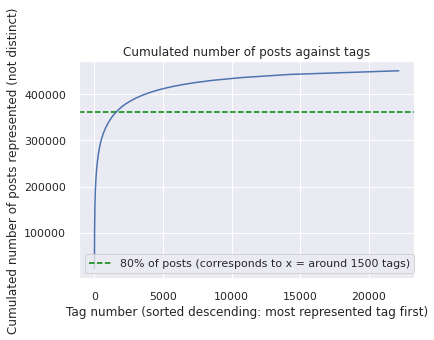

In [55]:
plt.title('Cumulated number of posts against tags')
plt.xlabel('Tag number (sorted descending: most represented tag first)')
plt.ylabel('Cumulated number of posts represented (not distinct)')
plt.axhline(tags_represented_posts_cumulated.max() * 0.80, color='green', linestyle='--', label=f"80% of posts (corresponds to x = around 1500 tags)")
plt.legend()
plt.plot(range(len(tags_represented_posts_cumulated)), tags_represented_posts_cumulated)

In [56]:
tags_represented_posts_cumulated[1500]

359098

# Frequency visualisation of tokens

In [84]:
#vectorizer = CountVectorizer(token_pattern = r"(?u)\b\w+\b") # this token pattern overrides default of min 2 letters for a word
vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w\w+\b|!|\?|\"|\'")
docs = vectorizer.fit_transform(df['Body'])

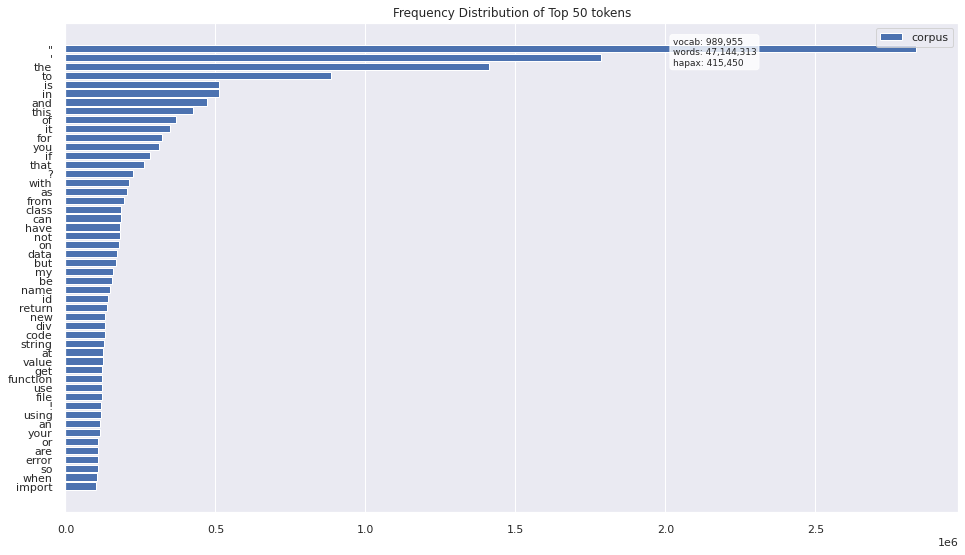

In [85]:
features = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
visualizer.poof()


In [81]:
np.min([len(f) for f in features])

1

## Most represented tokens

In [83]:
{k: v for k, v in sorted(tokens_body.items(), key=lambda item: item[1], reverse=True)}

{'.': 4366748,
 ',': 1898456,
 ':': 1566138,
 '(': 1554829,
 'the': 1300237,
 '-': 1190996,
 '=': 1086391,
 '"': 912889,
 'to': 866296,
 "'": 767934,
 '/': 764702,
 ')': 750420,
 'I': 709511,
 'a': 611425,
 '{': 596489,
 '0': 513006,
 '}': 495470,
 '>': 491863,
 'is': 488067,
 '<': 478578,
 ';': 473270,
 'in': 467558,
 'and': 442270,
 '1': 433985,
 '="': 369102,
 'of': 364987,
 'this': 361958,
 'it': 309435,
 '[': 306070,
 'for': 292650,
 'that': 253106,
 'you': 251592,
 ');': 248756,
 '2': 230658,
 '",': 226049,
 '</': 225342,
 'if': 224961,
 '()': 210266,
 'with': 204734,
 'i': 200774,
 'class': 181310,
 'have': 179610,
 'from': 177323,
 "',": 175709,
 'can': 174564,
 '\\': 172342,
 '$': 171600,
 'as': 170347,
 'not': 169013,
 'on': 167875,
 '("': 162088,
 ']': 161933,
 'data': 159934,
 '3': 157255,
 'be': 154878,
 '?': 154424,
 '#': 153182,
 '//': 152774,
 '+': 140520,
 '":': 140408,
 'return': 137583,
 'but': 135490,
 'my': 134379,
 's': 132393,
 't': 131942,
 'div': 131362,
 '|': 

# Annex

## Distinct tags covered against post numbers

cnt_docs = 0
cnt_nulltags = 0

cnt_distinct_tags_history = []
cnt_distinct_tags_current = 0

tokens_tags = nltk.FreqDist()

for tag_line in df['Tags']:
    '''
    if (cnt_docs < 10):
        print(tag_line)
        print(type(tag_line))
    '''
    
    if (str(tag_line) == 'nan'):
        cnt_nulltags +=1
    
    else:
        for word in tag_line.split():
            if (tokens_tags[word] == 0):
                cnt_distinct_tags_current += 1
                
            tokens_tags[word] += 1    
        
    cnt_distinct_tags_history.append(cnt_distinct_tags_current)
    
    cnt_docs += 1

plt.title('Cumulated number of distinct tags against post numbers')
plt.xlabel('Post ID')
plt.ylabel('Cumulated number of distinct tags represented')
plt.plot(range(cnt_docs), cnt_distinct_tags_history)